# U-OLO Switch Detection Notebook

In [1]:
import random

# Training

USE_GEOMETRIC_PREPROCESSING = False
SEGMENTATION_OBJECTIVE = 'rail' # 'track'

EPOCHS = 1
BATCH_SIZE = 16
IMAGE_SIZE = 640

SEED = random.randint(0, 1000)

# Dataset

WITH_CACHING = False # May cause issues if caching = True

TRAIN_SPLIT = 0.7
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.1

# "none" - No filters - 0| "no_switches" - Filter images with no switches - 5736 | "only_unknown" - Filter images with only unknown switches - 6246
# "unknown_switches" - Filter images with at least one unknown image - 7260 | "unkown_switches_keep_no"
FILTER_SWITCHES = "no_switches"

KEEP_UNKNOWN = False # Keep annotations of unknown switches

# Dataset preprocessing

BOX_ENLARGE_CONSTANT = 150
BOX_ENLARGE_PERCENT_HEIGHT = 1.25
BOX_ENLARGE_PERCENT_WIDTH = 1.25

THRESHOLD_FOR_ENLARGE = 1920 * 1080 # 1920 * 1080 -> enlarge all BBoxes

PRECISION = 6



BRANCH = 'uolo-extra-geometric-input' if USE_GEOMETRIC_PREPROCESSING else 'uolo-vanilla'

# Required Imports

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!git clone -b $BRANCH https://github.com/manole-alexandru/yolov5-uolo.git
!pip install -r yolov5-uolo/requirements.txt

%cd yolov5-uolo

import torch
from IPython.display import clear_output

clear_output()

print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 2.2.1+cu121 _CudaDeviceProperties(name='NVIDIA A100-SXM4-40GB', major=8, minor=0, total_memory=40513MB, multi_processor_count=108)


In [4]:
from os import listdir, remove
from os.path import isfile, join

import json
import numpy as np
import random
import shutil

# Replicability

In [5]:
import torch

def fix_seed(fixed_seed):

  torch.manual_seed(fixed_seed)
  np.random.seed(fixed_seed)
  random.seed(fixed_seed)
  torch.cuda.manual_seed(fixed_seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

fix_seed(SEED)

# Image preprocessing

In [6]:
import cv2
import numpy as np
import time

def open_image(img_path):
    return cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

def to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def naive_remover(grayscale_img):

    REMOVED_PERCENT = 0.35

    naive_mask = np.ones(grayscale_img.shape)
    height, _ = grayscale_img.shape[:2]

    naive_mask[0 : int(height * REMOVED_PERCENT), :] = 0
    naive_mask = cv2.convertScaleAbs(naive_mask)

    return cv2.bitwise_and(grayscale_img, grayscale_img, mask=naive_mask)

def sky_remover(grayscale_img):
    # Might work only on day imgs

    THRESHOLD = 170
    UPPER_PERCENTAGE = 0.9
    MAX_SKY_POLYGONS = 5

    ret, thresh_img = cv2.threshold(grayscale_img, THRESHOLD, 255, cv2.THRESH_BINARY)

    # cv2.imshow("threshold", thresh_img)
    # cv2.waitKey(0)

    contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    sky_countours = []
    height, _ = grayscale_img.shape[:2]

    for cidx, countour in enumerate(contours):
        upper_points = 0
        for point in countour:
            countour_point = point[0]
            if countour_point[1] < height // 2:
                upper_points += 1

        contour_upper_percetange = upper_points / len(countour)
        if contour_upper_percetange > UPPER_PERCENTAGE:
            sky_countours.append(countour)
        if cidx >= MAX_SKY_POLYGONS:
            break


    img_contours = np.zeros(grayscale_img.shape)
    cv2.drawContours(img_contours, sky_countours, -1, (255), 3)

    # cv2.imshow("countour", img_contours)
    # cv2.waitKey(0)

    for sky_countour in sky_countours:
        cv2.fillPoly(img_contours, pts =[sky_countour], color=(255))

    masked_sky_image = cv2.bitwise_not(cv2.convertScaleAbs(img_contours))

    return cv2.bitwise_and(grayscale_img, grayscale_img, mask=masked_sky_image)
    # cv2.imshow("filled", img_contours)
    # cv2.waitKey(0)

def get_countours(grayscale_img):

    MIN_LINES_IN_POLYGONE = 1
    MAX_LINES_IN_POLYGONE = 10
    MIN_PERIMETER = 600
    MAX_PERIMETER = 5000
    CANNY_THRESHOLD1 = 30
    CANNY_THRESHOLD2 = 200

    edged = cv2.Canny(grayscale_img, threshold1=CANNY_THRESHOLD1, threshold2=CANNY_THRESHOLD2)
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    new_contours = []
    for c in contours:
        perimeter = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.018 * perimeter, True)
        length = len(approx)
        if perimeter > MIN_PERIMETER and perimeter < MAX_PERIMETER and length < MAX_LINES_IN_POLYGONE and length > MIN_LINES_IN_POLYGONE:
            new_contours.append(c)

    to_be_returned = np.zeros(grayscale_img.shape)
    cv2.drawContours(to_be_returned, new_contours, -1, (255, 255, 255), 3)
    return to_be_returned


def image_preprocessing(image_path):
  img = open_image(image_path)
  grayscale_img = to_grayscale(img)
  sky_removed = naive_remover(grayscale_img)
  result = get_countours(sky_removed)
  return result

# Get Dataset

In [7]:
if WITH_CACHING and FILTER_SWITCHES == "none":
  # TO DO: Make this smarter (Caching does not work with the whole dataset for the whole dataset)
  TRAIN_SPLIT /= 2
  VALIDATION_SPLIT /= 2
  TEST_SPLIT /= 2

if FILTER_SWITCHES == 'unknown_switches' or not KEEP_UNKNOWN:
  CLASSES = {'switch-left':0, 'switch-right': 1}
else:
  CLASSES = {'switch-left':0, 'switch-right': 1, 'switch-unknown': 2}

print(CLASSES)

{'switch-left': 0, 'switch-right': 1}


In [8]:
!mkdir ../datasets
!cp ../gdrive/MyDrive/Colab\ Notebooks/rs19_val.zip ../datasets
!unzip -qo ../datasets/rs19_val.zip -d ../datasets/

In [9]:
# !rm -rf ../datasets/uint8
!rm -rf ../datasets/authors.txt
!rm -rf ../datasets/example-vis.py
!rm -rf ../datasets/license.txt
!rm -rf ../datasets/readme.txt
!rm -rf ../datasets/rs19-config.json
!rm -rf ../datasets/rs19_val.zip

In [10]:
!mv ../datasets/jpgs/rs19_val ../datasets/images
!rm -rf ../datasets/jpgs
!mkdir ../datasets/labels/

In [11]:
!mv ../datasets/uint8/rs19_val ../datasets/
!mv ../datasets/rs19_val/ ../datasets/mask

In [12]:
!mkdir ../datasets/train/
!mkdir ../datasets/train/images/
!mkdir ../datasets/train/masks/
!mkdir ../datasets/train/labels/
!mkdir ../datasets/val/
!mkdir ../datasets/val/images/
!mkdir ../datasets/val/masks/
!mkdir ../datasets/val/labels/
!mkdir ../datasets/test/
!mkdir ../datasets/test/images/
!mkdir ../datasets/test/masks/
!mkdir ../datasets/test/labels/

In [13]:
# change mask to binary
import cv2

mask_path = '/content/datasets/mask/'
onlymasks = [f for f in listdir(mask_path) if isfile(join(mask_path, f))]

for mask_file in onlymasks:
  full_mask_path = mask_path + mask_file
  img = cv2.imread(full_mask_path, cv2.IMREAD_GRAYSCALE)
  if SEGMENTATION_OBJECTIVE == 'track':
    img[img == 3] = 17
    img[img == 12] = 17
  img[img < 17] = 0
  img[img > 18] = 0
  img[img == 17] = 255
  img[img == 18] = 255
  cv2.imwrite(full_mask_path, img)

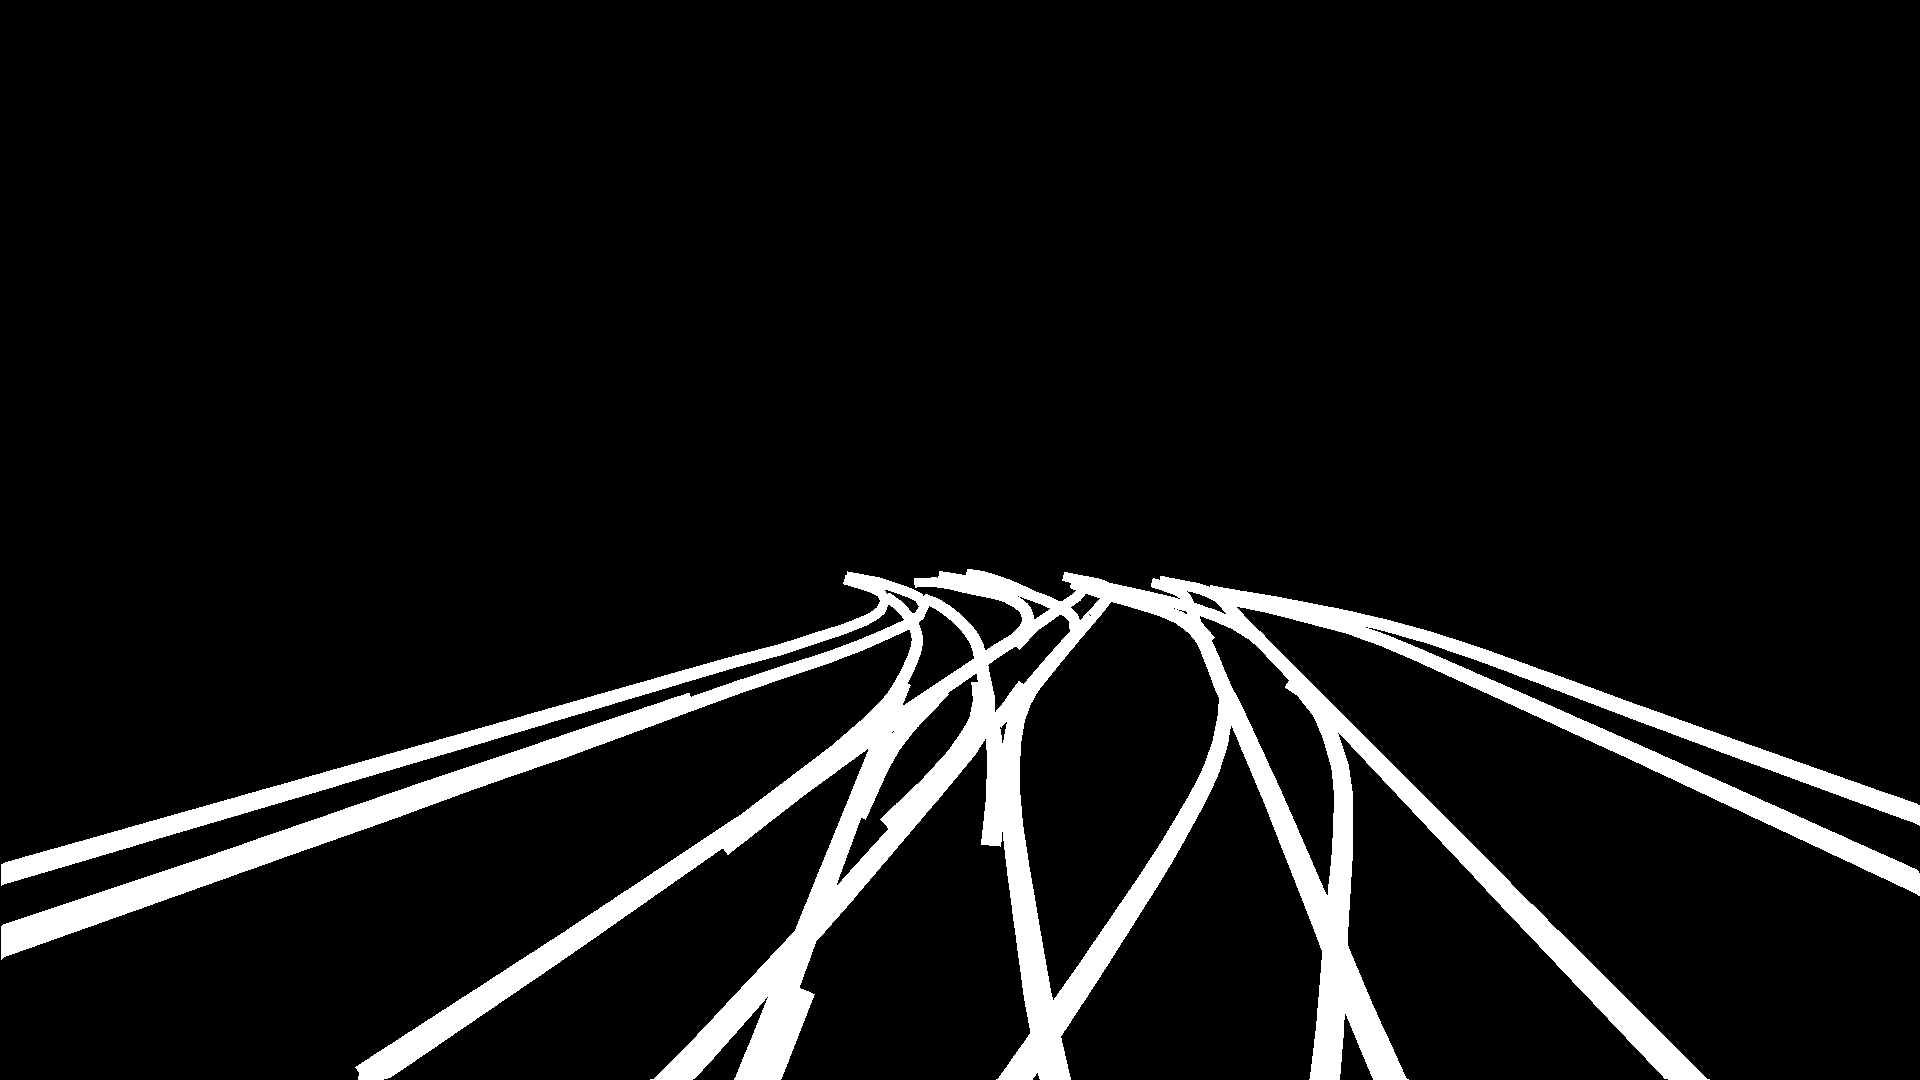

In [14]:
from google.colab.patches import cv2_imshow

full_mask_path = '/content/datasets/mask/rs00007.png'
img = cv2.imread(full_mask_path, cv2.IMREAD_GRAYSCALE)
cv2_imshow(img)

In [15]:
def bbox_to_yolo_annotation(bbox, img_height, img_width):
  x1, y1, x2, y2 = bbox[0], bbox[1], bbox[2], bbox[3]
  x = (x1 + x2) // 2
  y = (y1 + y2) // 2
  h = y2 - y1
  w = x2 - x1

  if w * h <= THRESHOLD_FOR_ENLARGE:
    w += BOX_ENLARGE_CONSTANT
    h += BOX_ENLARGE_CONSTANT
    h *= BOX_ENLARGE_PERCENT_HEIGHT
    w *= BOX_ENLARGE_PERCENT_WIDTH

  x /= img_width
  w /= img_width
  y /= img_height
  h /= img_height

  return round(x, PRECISION), round(y, PRECISION), round(w, PRECISION), round(h, PRECISION)

def json_to_label_file(full_path, labels_folder='../datasets/labels/'):

  f = open(full_path)
  data = json.load(f)
  frame_name = data['frame']
  label_file = open(labels_folder + frame_name + '.txt', "w")

  img_height = data['imgHeight']
  img_width = data['imgWidth']
  objects = data['objects']

  found_unknown = False
  found_annotated = False
  found_obj = False
  for obj in objects:
    if obj['label'] in CLASSES:
      found_obj = True
      bbox = obj['boundingbox']
      x, y, w, h = bbox_to_yolo_annotation(bbox, img_height, img_width)

      class_label = CLASSES[obj['label']]
      # if class_label < 3:
      found_annotated = True
      label_file.write(f'{class_label} {x} {y} {w} {h}\n')

    if obj['label'] == 'switch-unknown':
      found_unknown = True

  if FILTER_SWITCHES == "only_unknown" and found_annotated == False and found_unknown == True:
    found_obj = False

  if FILTER_SWITCHES == "unknown_switches" and found_unknown == True:
    found_obj = False

  if FILTER_SWITCHES == "unkown_switches_keep_no" and found_unknown == True:
    found_obj = False


  f.close()
  label_file.close()
  if FILTER_SWITCHES != "none" and found_obj == False:
    if FILTER_SWITCHES == "unkown_switches_keep_no" and found_unknown == False:
      return 0
    else:
      remove(labels_folder + frame_name + '.txt')
      base_folder = '/'.join(labels_folder.split('/')[:-2])
      image_folder = base_folder + '/images/'
      mask_folder = base_folder+ '/mask/'
      remove(image_folder + frame_name + '.jpg')
      remove(mask_folder + frame_name + '.png')
      return 1
  return 0


def create_label_files():
    mypath = '/content/datasets/jsons/rs19_val/'
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    no_files = len(onlyfiles)

    filtered_files = 0
    for file_id, json_file in enumerate(onlyfiles):
      filtered_files += json_to_label_file(mypath + json_file)
      # if file_id == 99:
      #  break
      # break # Do Not Forget To Remove This

    print(filtered_files, 'images were filtered.')
    return no_files - filtered_files

no_files = create_label_files()
print('Created dataset has', no_files, 'images.')

6246 images were filtered.
Created dataset has 2254 images.


In [16]:
mypath = '/content/datasets/images/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
no_files = len(onlyfiles)
print(no_files)

2254


In [17]:
# Add preprocessed extra channel
!mkdir ../datasets/preprocessed/
!mkdir ../datasets/train/preprocessed/
!mkdir ../datasets/val/preprocessed/
!mkdir ../datasets/test/preprocessed/

In [18]:
preprocessed_path = '/content/datasets/preprocessed/'
images_path = '/content/datasets/images/'
onlyimages = [f for f in listdir(images_path) if isfile(join(images_path, f))]
mean_t = 0

for image_file in onlyimages:
  preprocessed_image = image_preprocessing(images_path + image_file)
  cv2.imwrite(preprocessed_path + image_file, preprocessed_image)

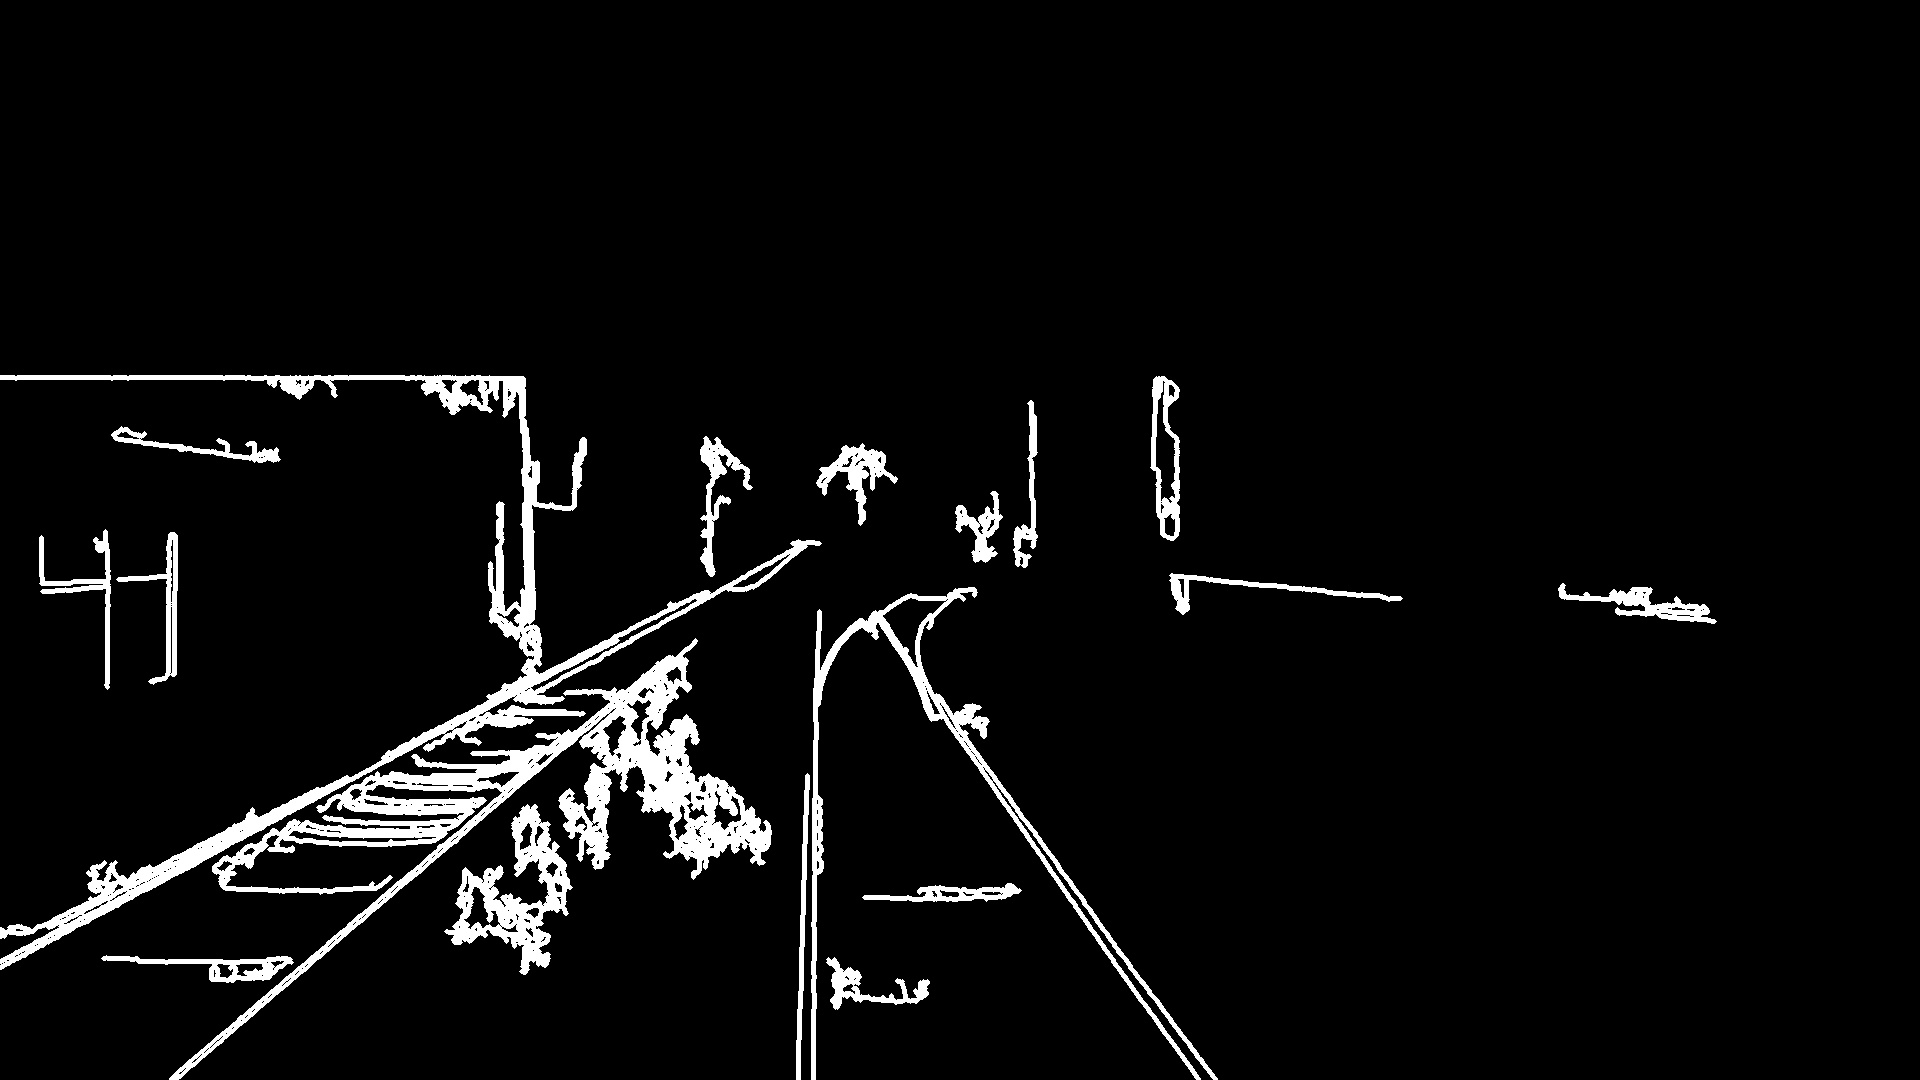

In [19]:
from google.colab.patches import cv2_imshow

full_mask_path = '/content/datasets/preprocessed/rs00024.jpg'
img = cv2.imread(full_mask_path, cv2.IMREAD_GRAYSCALE)
cv2_imshow(img)

In [20]:
train_images = int(no_files * TRAIN_SPLIT)
val_images = int(no_files * VALIDATION_SPLIT)
test_images = int(no_files * TEST_SPLIT)

image_path = '/content/datasets/images/'
onlyimages = [f for f in listdir(image_path) if isfile(join(image_path, f))]
onlyimages.sort()

mask_path = '/content/datasets/mask/'
onlymasks = [f for f in listdir(mask_path) if isfile(join(mask_path, f))]
onlymasks.sort()

preprocessed_path = '/content/datasets/preprocessed/'
onlypreprocessed = [f for f in listdir(preprocessed_path) if isfile(join(preprocessed_path, f))]
onlypreprocessed.sort()

label_path = '/content/datasets/labels/'
onlylabels = [f for f in listdir(label_path) if isfile(join(label_path, f))]
onlylabels.sort()


for pair_no, (image_file, mask_file, labele_file, preprocessed_file) in enumerate(zip(onlyimages, onlymasks, onlylabels, onlypreprocessed)):
  # print(pair_no)
  if pair_no < train_images:
    shutil.move(image_path + image_file, '/content/datasets/' + 'train/images/' + image_file)
    shutil.move(mask_path + mask_file, '/content/datasets/' + 'train/masks/' + mask_file)
    shutil.move(label_path + labele_file, '/content/datasets/' + 'train/labels/' + labele_file)
    shutil.move(preprocessed_path + preprocessed_file, '/content/datasets/' + 'train/preprocessed/' + preprocessed_file)
  elif pair_no < train_images + val_images:
    shutil.move(image_path + image_file, '/content/datasets/' + 'val/images/' + image_file)
    shutil.move(mask_path + mask_file, '/content/datasets/' + 'val/masks/' + mask_file)
    shutil.move(label_path + labele_file, '/content/datasets/' + 'val/labels/' + labele_file)
    shutil.move(preprocessed_path + preprocessed_file, '/content/datasets/' + 'val/preprocessed/' + preprocessed_file)
  elif pair_no < train_images + val_images + test_images:
    shutil.move(image_path + image_file, '/content/datasets/' + 'test/images/' + image_file)
    shutil.move(mask_path + mask_file, '/content/datasets/' + 'test/masks/' + mask_file)
    shutil.move(label_path + labele_file, '/content/datasets/' + 'test/labels/' + labele_file)
    shutil.move(preprocessed_path + preprocessed_file, '/content/datasets/' + 'test/preprocessed/' + preprocessed_file)
  else:
    break

In [21]:
!rm -rf ../datasets/jsons/
!rm -rf ../datasets/images/
!rm -rf ../datasets/labels/
!rm -rf ../datasets/uint8/
!rm -rf ../datasets/mask/
!rm -rf ../datasets/preprocessed/

In [22]:
cfg_file = open('/content/datasets/data.yaml', "w")

cfg_file.write('train: ../datasets/train/images\n')
cfg_file.write('val: ../datasets/val/images\n')
cfg_file.write('test: ../datasets/test/images\n')

cfg_file.write(f'nc: {len(CLASSES)}\n')

if len(CLASSES) == 3:
  cfg_file.write('names: [\'switch-left\', \'switch-right\', \'switch-unknown\']')
else:
  cfg_file.write('names: [\'switch-left\', \'switch-right\']')

cfg_file.close()

# Dataset Information

In [ ]:
def sum_dict(dict1, dict2):
  for key in dict1:
    dict1[key] += dict2[key]
  return dict1


def get_instances_from_labels(label_path):
  f = open(label_path, "r")
  instances = [0, 0, 0]
  for x in f:
    switch_class = int(x.split(' ')[0])
    instances[switch_class] += 1
  return instances

def get_files_from_folder(folder_path):
  return [folder_path + '/' + f for f in listdir(folder_path) if isfile(join(folder_path, f))]

def get_image_annotation_pair_from_folder(folder_path):
  return (get_files_from_folder(folder_path + '/images'), get_files_from_folder(folder_path + '/labels'))

def compute_instances_from_folder(folder_path):
  images, labels = get_image_annotation_pair_from_folder(folder_path)
  info = {'0_images': 0, '0_instances': 0, '1_images': 0, '1_instances': 0, '2_images': 0, '2_instances': 0, 'no_images': 0}
  for (i, l) in zip(images, labels):
    switch = False
    instances = get_instances_from_labels(l)
    info['0_instances'] += instances[0]
    info['1_instances'] += instances[1]
    info['2_instances'] += instances[2]
    if instances[0] > 0:
      info['0_images'] += 1
      switch = True
    if instances[1] > 0:
      info['1_images'] += 1
      switch = True
    if instances[2] > 0:
      info['2_images'] += 1
      switch = True
    if switch == False:
      info['no_images'] += 1
  return info


info_test = compute_instances_from_folder('/content/datasets/test')
info_val = compute_instances_from_folder('/content/datasets/val')
info_train = compute_instances_from_folder('/content/datasets/train')
print(info_test)
info_test = sum_dict(info_test, info_val)
print(info_test)
info_total = sum_dict(info_test, info_train)
print(info_total)

# Clear Cache & Model Config

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

torch.cuda.memory_summary(device=None, abbreviated=False)

In [25]:
!cp ./models/yolov5m.yaml ./models/custom_yolov5m.yaml
cfg = './models/custom_yolov5m.yaml'

with open(cfg, 'r') as yamlFile:
  yamlData = yamlFile.read()

yamlData = yamlData.replace('nc: 80', f'nc: {len(CLASSES)}')

with open(cfg, 'w') as yamlFile:
  yamlFile.write(yamlData)

# Train

In [ ]:
!python train.py --img $IMAGE_SIZE --batch $BATCH_SIZE --epochs $EPOCHS --data '../datasets/data.yaml' --cfg ./models/custom_yolov5m.yaml --weights yolov5m.pt --name uolo5_results --hyp 'data/hyps/hyp.scratch-med.yaml'

In [ ]:
!python val.py --img $IMAGE_SIZE --data '../datasets/data.yaml' --weights '/content/yolov5-uolo/runs/train/uolo5_results/weights/best_seg.pt'

In [ ]:
!python val.py --img $IMAGE_SIZE --data '../datasets/data.yaml' --weights '/content/yolov5-uolo/runs/train/uolo5_results/weights/best.pt' --single-cls

# Inference

In [33]:
def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, ratio, (dw, dh)

im0 = cv2.imread("/content/datasets/test/images/rs08415.jpg", cv2.IMREAD_COLOR)
im = letterbox(im0)[0]  # padded resize
im = im.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
im = np.ascontiguousarray(im)  # contiguous
im = torch.from_numpy(im)
im = im.half()
im /= 255  # 0 - 255 to 0.0 - 1.0
if len(im.shape) == 3:
  im = im[None]  # expand for batch dim
im = im.to("cuda")

In [ ]:
model = torch.load('/content/yolov5-uolo/runs/train/uolo5_results/weights/best.pt')
model = model['model'].to("cuda")
model.eval()

In [35]:
output = model(im)

In [ ]:
def compute_seg_iou(pred, target, n_classes=2):
    ious = []
    pred = torch.sigmoid(pred)
    pred[pred < 0.5] = 0
    pred[pred >= 0.5] = 1
    pred = pred.view(-1)
    target = target.view(-1)
    # print(target)
    # print(pred)

    # Ignore IoU for background class ("0")
    for cls in range(1, n_classes):  # This goes from 1:n_classes-1 -> class "0" is ignored
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds[target_inds]).long().sum().data.cpu()  # Cast to long to prevent overflows
        union = pred_inds.long().sum().data.cpu() + target_inds.long().sum().data.cpu() - intersection
        if union == 0:
            ious.append(float('nan'))  # If there is no ground truth, do not include in evaluation
        else:
            ious.append(float(intersection) / float(max(union, 1)))
    return np.array(ious)

pred = output[1]
seg_mask = cv2.imread("/content/datasets/train/images/rs00007.jpg", cv2.IMREAD_COLOR)
seg_mask = cv2.cvtColor(seg_mask, cv2.COLOR_BGR2GRAY)
seg_mask = cv2.resize(seg_mask, (640, 384), interpolation = cv2.INTER_LINEAR)
# print(seg_mask.shape)
cv2_imshow(seg_mask)
torch_segmask = torch.from_numpy(seg_mask)
torch_segmask = torch_segmask / 255.0
print(compute_seg_iou(pred, torch_segmask))

In [45]:
import torch
pred = output[1]
pred = torch.sigmoid(pred)
pred[pred < 0.5] = 0
pred[pred >= 0.5] = 1
numpy_pred = pred.cpu().numpy()
numpy_pred = numpy_pred[0][0]
numpy_pred = numpy_pred * 255
print(numpy_pred.shape)

(384, 640)


In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(numpy_pred)

In [ ]:
!python detect.py --source /content/datasets/test/images/ --data '../datasets/data.yaml' --weights /content/yolov5-uolo/runs/train/uolo5_results/weights/best.pt